# Trying to generate Music with JSBChorales using VAE

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import joblib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
X = datas['X']
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # to 1 channel

from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=64, shuffle=True)


In [8]:
def loss_function(x, x_hat, mean, log_var):
    #reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = 0 # - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [73]:
class BachVAE(nn.Module):
    def __init__(self):
        super(BachVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 2, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2)
        )
        
        self.d1 = nn.Dropout(0.2)
        self.ztodec = nn.Linear(32, 1024)

        self.mean_layer = nn.Linear(240, 32)
        self.logvar_layer = nn.Linear(240, 32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 256, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=(9, 7), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 1, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2)
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.d1(x)
        x = x.flatten(1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        z = self.ztodec(z)
        z = z.view(z.shape[0], 8, 8, 16)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


model = BachVAE().to(device)
optim = Adam(model.parameters(), lr=0.001)
criterion = loss_function


In [76]:
model.train()
for epoch in range(200):
    for batch_idx, x in enumerate(dataloader):
        x = x.float().to(device)
        optim.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()
        optim.step()

    print(epoch, loss.item())

0 4327.859375
1 5117.203125
2 5282.45751953125
3 4454.0458984375
4 4650.4970703125
5 4366.71484375
6 4537.69189453125
7 4351.25146484375
8 4385.48974609375
9 4393.3916015625
10 5167.93505859375
11 4403.7744140625
12 4562.9267578125
13 4580.00732421875
14 4124.8203125
15 4294.63037109375


KeyboardInterrupt: 

torch.Size([64, 1, 128, 100])


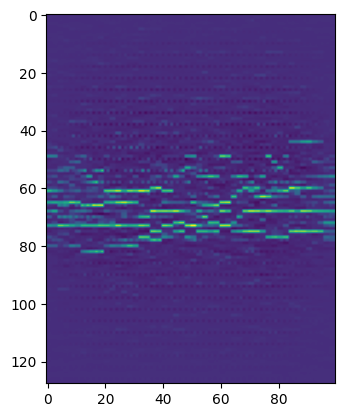

In [79]:
model.eval()
with torch.no_grad():
    _x = x.float().to(device)
    _x_hat, mean, log_var = model(_x)

_x_hat = _x_hat.cpu().numpy()[1, 0, :, :]
print(x_hat.shape)
plt.imshow(_x_hat)

# Generating new Samples from Latent Space

In [89]:
def generate_sample(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

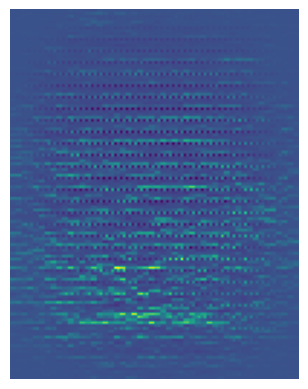

tensor([[-0.0030, -0.0030, -0.0032,  ..., -0.0039, -0.0044, -0.0044],
        [-0.0026, -0.0026, -0.0019,  ..., -0.0041, -0.0022, -0.0024],
        [-0.0043, -0.0037, -0.0052,  ..., -0.0018, -0.0030, -0.0028],
        ...,
        [-0.0028, -0.0027, -0.0020,  ..., -0.0015, -0.0016, -0.0018],
        [-0.0041, -0.0038, -0.0044,  ..., -0.0017, -0.0019, -0.0013],
        [-0.0045, -0.0048, -0.0042,  ..., -0.0004, -0.0004, -0.0004]])

In [93]:
latent_vector = torch.rand(8, 8, 16).to(device)
generate_sample(latent_vector)

# Generating Samples from learned Distribution

In [94]:
def generate_sample_distr(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

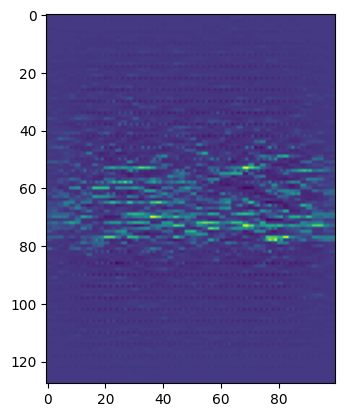

In [115]:
with torch.no_grad():
    mean = torch.rand(1, 32).to(device)
    logvar = torch.rand(1, 32).to(device)

    z = model.reparameterization(mean, logvar)
    z = model.ztodec(z)
    z = z.view(z.shape[0], 8, 8, 16)
    new_sample = model.decode(z)

new_sample = new_sample.cpu().numpy()[0, 0, :, :]

plt.imshow(new_sample)

### Per quanto è ancora molto basilare è promettente (credo)

In [112]:
torch.save(model.state_dict(), "BachVAE1.pt")


In [114]:
model.load_state_dict(torch.load("/kaggle/working/BachVAE1.pt", weights_only=True))
model.eval()

BachVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 256, kernel_size=(16, 16), stride=(4, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(256, 2, kernel_size=(4, 4), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
  )
  (d1): Dropout(p=0.2, inplace=False)
  (ztodec): Linear(in_features=32, out_features=1024, bias=True)
  (mean_layer): Linear(in_features=240, out_features=32, bias=True)
  (logvar_layer): Linear(in_features=240, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(256, 256, kernel_size=(9, 7), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(256, 1, kernel_size=(16, 16), stride=(4, 2))
    (5): LeakyReLU(negative_slope=0.2)
  )
)